In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
from BaselineRemoval import BaselineRemoval
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import torch
from torch.utils.data import TensorDataset
import torch
from torch import nn
import numpy as np
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from torch.utils.data import TensorDataset


In [2]:
DATALABEL = ['ear lobe','inner arm','thumb nail','median cubital vein']
WATCH_PROB_PREDICT = False ## if you want to observe the probability of each choice
PLT = '/root/projects/ProjectAug22/CP/Diabete_detection_withRamanSpec/dataset/' ## change to the path to dataset
PLT_mac = '/Volumes/ExternalSSDForMac/AITLecture/CSforDSAIAUG22/_CP_project/DataScienceAndMLProjects/Diabete_detection_withRamanSpec/dataset'
SMOOTH = True

## 1. ETL

In [3]:
from src import spectrumloader as spl

In [4]:
standard,data_all = spl.read_file('dataset/')

In [5]:
Xs,ys,_ = spl.cut_tonumpy(data_all)

In [6]:
assert len(Xs) == 4, 'DATA error'

## 2.Train test split (with same seed)

In [7]:
X_trainall,_,y_trainall,_ = spl.split_train_test(Xs,ys)
y_train0,y_train1,y_train2,y_train3 = y_trainall

## 3. EDA [here](https://github.com/AtiChetsurakul/DataScienceAndMLProjects/blob/main/Diabete_detection_withRamanSpec/datawatcher.ipynb)
- To shorten the file, eda not inculded

## 4. spectrum tranformation 
- incuding
    - Fluoresence removal
    - Correcting baseline
    - Normalization
## ORDER OF DATA ARE
>(0) ear lobe

>(1) inner arm 

>(2) thumb nail 

>(3) median cubital vein


In [8]:
X_train_VR = spl.fluoresence_removal(X_trainall)

if SMOOTH:
    X_train_VR = spl.savitzky_smooth(X_train_VR)


In [9]:
X_train0_std,X_train1_std,X_train2_std,X_train3_std,normalizer = spl.seting_normalized_fuoresence_smoothing(True,True,X_train_VR)

assert len(normalizer) == 4, 'Normalizer is not here'

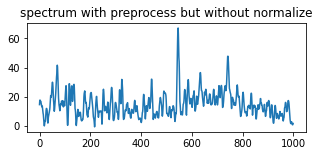

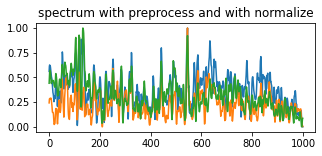

In [10]:
# Check by plot
plt.figure(figsize=(5,2))
plt.plot(X_train_VR[0][0])
plt.title('spectrum with preprocess but without normalize')
plt.show()
plt.figure(figsize=(5,2))
plt.title('spectrum with preprocess and with normalize')
plt.plot(X_train1_std[0])
plt.plot(X_train1_std[7])
plt.plot(X_train1_std[2])

plt.show()

## 5. apply data to pytorch

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [12]:
ds_earloop = TensorDataset(torch.FloatTensor(X_train0_std),torch.LongTensor(y_train0))
ds_inarm = TensorDataset(torch.FloatTensor(X_train1_std),torch.LongTensor(y_train1))
ds_thumbnail = TensorDataset(torch.FloatTensor(X_train2_std),torch.LongTensor(y_train2))
ds_vain = TensorDataset(torch.FloatTensor(X_train3_std),torch.LongTensor(y_train3))

train_set0, val_set0 = torch.utils.data.random_split(ds_earloop, [12, 4])
train_set1, val_set1 = torch.utils.data.random_split(ds_inarm, [12, 4])
train_set2, val_set2 = torch.utils.data.random_split(ds_thumbnail, [12, 4])
train_set3, val_set3 = torch.utils.data.random_split(ds_vain, [12, 4])

In [13]:
batch_size = 12
valbatch_size = 4


train_loader0 = torch.utils.data.DataLoader(dataset=train_set0,batch_size=batch_size,shuffle=True)
val_loader0 = torch.utils.data.DataLoader(dataset=val_set0, batch_size=valbatch_size, shuffle=True)

train_loader1 = torch.utils.data.DataLoader(dataset=train_set1,batch_size=batch_size,shuffle=True)
val_loader1 = torch.utils.data.DataLoader(dataset=val_set1, batch_size=valbatch_size, shuffle=True)

train_loader2 = torch.utils.data.DataLoader(dataset=train_set2,batch_size=batch_size,shuffle=True)
val_loader2 = torch.utils.data.DataLoader(dataset=val_set2, batch_size=valbatch_size, shuffle=True)

train_loader3 = torch.utils.data.DataLoader(dataset=train_set3,batch_size=batch_size,shuffle=True)
val_loader3 = torch.utils.data.DataLoader(dataset=val_set3, batch_size=valbatch_size, shuffle=True)


train_loader_all = [train_loader0,train_loader1,train_loader2,train_loader3]
val_loader_all = [val_loader0,val_loader1,val_loader2,val_loader3]


In [14]:
def shuffleloadertorch(ds_earloop,ds_inarm,ds_thumbnail,ds_vain,seed,train_size = 12, val_size = 4):
    '''This function'''
    torch.manual_seed(seed)
    train_set0, val_set0 = torch.utils.data.random_split(ds_earloop, [train_size, val_size])
    train_set1, val_set1 = torch.utils.data.random_split(ds_inarm, [train_size, val_size])
    train_set2, val_set2 = torch.utils.data.random_split(ds_thumbnail, [train_size, val_size])
    train_set3, val_set3 = torch.utils.data.random_split(ds_vain, [train_size, val_size])

    train_loader0 = torch.utils.data.DataLoader(dataset=train_set0,batch_size=batch_size,shuffle=True)
    val_loader0 = torch.utils.data.DataLoader(dataset=val_set0, batch_size=valbatch_size, shuffle=True)

    train_loader1 = torch.utils.data.DataLoader(dataset=train_set1,batch_size=batch_size,shuffle=True)
    val_loader1 = torch.utils.data.DataLoader(dataset=val_set1, batch_size=valbatch_size, shuffle=True)

    train_loader2 = torch.utils.data.DataLoader(dataset=train_set2,batch_size=batch_size,shuffle=True)
    val_loader2 = torch.utils.data.DataLoader(dataset=val_set2, batch_size=valbatch_size, shuffle=True)

    train_loader3 = torch.utils.data.DataLoader(dataset=train_set3,batch_size=batch_size,shuffle=True)
    val_loader3 = torch.utils.data.DataLoader(dataset=val_set3, batch_size=valbatch_size, shuffle=True)


    train_loader_all = [train_loader0,train_loader1,train_loader2,train_loader3]
    val_loader_all = [val_loader0,val_loader1,val_loader2,val_loader3]
    return train_loader_all,val_loader_all


## 6. modeling
- ### 6.simple
    - ### ANN

In [15]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()  #super(Model, self)
        self.fc1 = nn.Linear(input_size, hidden_size) 
        #add non-linearity; recall ReLU is max(input, 0) 
        self.snm = nn.Softmax(dim=1)
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.snm(out)
        out = self.fc2(out)
        return out

In [16]:
model_for_earloop = NeuralNet(1000, 14, 2).to(device)
model_for_inarm = NeuralNet(1000, 14, 2).to(device)
model_for_thumbnail = NeuralNet(1000, 14, 2).to(device)
model_for_vain = NeuralNet(1000, 14, 2).to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_for_vain.parameters(), lr=0.0001)  

annsim_models = [model_for_earloop,model_for_inarm,model_for_thumbnail,model_for_vain]
annsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
annsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [17]:
total_step = len(train_loader0)  #for printing purpose
num_epochs = 5000
train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []
for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(annsim_models,annsim_criterions,annsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / len(val_set0)
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')

    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [10000/10000], Step [1/1], Loss: 0.1065   ++++++Validation++++++  Loss: 0.83 - Acc: 50.00 
 END OF MODEL for ear lobe with val acc = 50.0
Epoch [10000/10000], Step [1/1], Loss: 0.1070   ++++++Validation++++++  Loss: 0.68 - Acc: 75.00 
 END OF MODEL for inner arm with val acc = 75.0
Epoch [10000/10000], Step [1/1], Loss: 0.1032   ++++++Validation++++++  Loss: 1.66 - Acc: 25.00 
 END OF MODEL for thumb nail with val acc = 25.0
Epoch [10000/10000], Step [1/1], Loss: 0.1145   ++++++Validation++++++  Loss: 2.32 - Acc: 0.00 
 END OF MODEL for median cubital vein with val acc = 0.0


#### loss plot

In [18]:
from src import trainResult_show as mtp

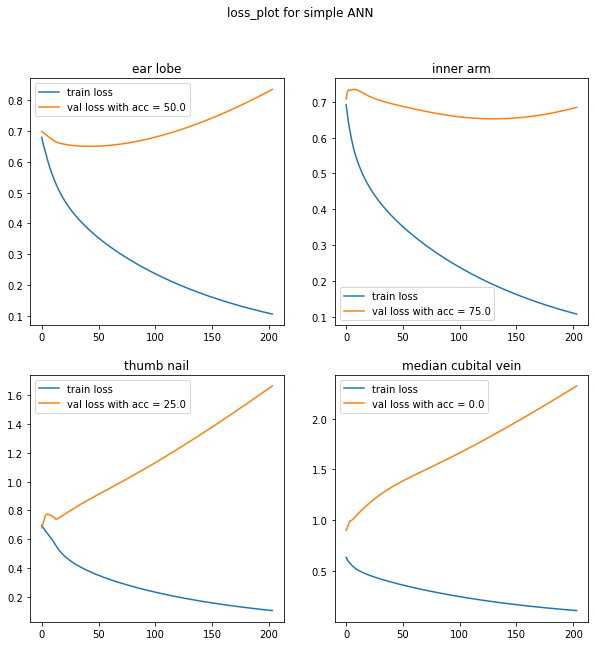

In [19]:
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'simple ANN')

- ### 6. Intermediate

    - Dropout ANN

In [20]:
class IntANN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()  #super(Model, self)
        self.fc1 = nn.Linear(input_size, hidden_size) 
        #add non-linearity; recall ReLU is max(input, 0) 
        self.snm = nn.Softmax(dim=1)
        self.do1 = nn.Dropout(p=.5)
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.snm(out)
        out = self.do1(out)
        out = self.fc2(out)
        return out


In [21]:
model_for_earloop = IntANN(1000, 14, 2).to(device)
model_for_inarm = IntANN(1000, 14, 2).to(device)
model_for_thumbnail = IntANN(1000, 14, 2).to(device)
model_for_vain = IntANN(1000, 14, 2).to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_for_vain.parameters(), lr=0.0001)  

annint_models = [model_for_earloop,model_for_inarm,model_for_thumbnail,model_for_vain]
annint_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
annint_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [22]:
total_step = len(train_loader0)  #for printing purpose
num_epochs = 5000
train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []
for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(annint_models,annint_criterions,annint_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            with torch.no_grad():
                model.eval()
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / valbatch_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')

    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [10000/10000], Step [1/1], Loss: 0.2739   ++++++Validation++++++  Loss: 0.79 - Acc: 50.00 
 END OF MODEL for ear lobe with val acc = 50.0
Epoch [10000/10000], Step [1/1], Loss: 0.4726   ++++++Validation++++++  Loss: 0.84 - Acc: 50.00 
 END OF MODEL for inner arm with val acc = 50.0
Epoch [10000/10000], Step [1/1], Loss: 0.3336   ++++++Validation++++++  Loss: 1.29 - Acc: 25.00     ++++++Validation++++++  Loss: 1.25 - Acc: 25.00     ++++++Validation++++++  Loss: 1.25 - Acc: 25.00 
 END OF MODEL for thumb nail with val acc = 25.0
Epoch [10000/10000], Step [1/1], Loss: 0.4175   ++++++Validation++++++  Loss: 2.23 - Acc: 0.00     ++++++Validation++++++  Loss: 1.97 - Acc: 0.00 
 END OF MODEL for median cubital vein with val acc = 0.0


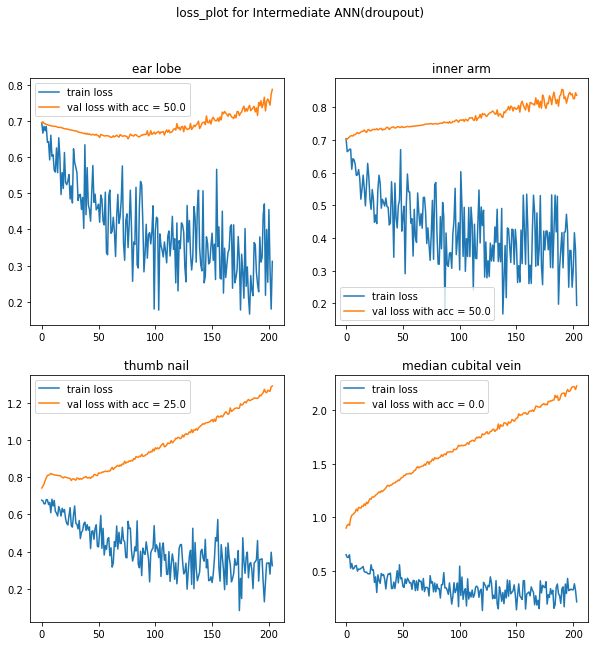

In [23]:
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'Intermediate ANN(droupout)')

- ### 6.simple
    - ### CNN

In [24]:
class RamConv1d(nn.Module):
    def __init__(self, input_size = 1, hidden_size=50,linear_hidden=14, out_size=2):
        super().__init__()
        self.conv1d   = nn.Conv1d(input_size, hidden_size, kernel_size = 3)
        self.linear1 = nn.Linear(49900, linear_hidden) #taking the last hidden state
        self.linear2 = nn.Linear(linear_hidden, out_size)
        
    def forward(self, seq):
        #seq shape: (10, 1, 1000)
        out = self.conv1d(seq)
        #out shape: (10, 50, 998)
        out = out.reshape(seq.size(0), -1)
        # print(out.shape)
        out = self.linear1(out)
        out = self.linear2(out)
        return out

In [25]:
# .reshape(spec.shape[0],1,-1)

In [26]:
modelcnn_for_earloop = RamConv1d().to(device)
modelcnn_for_inarm = RamConv1d().to(device)
modelcnn_for_thumbnail = RamConv1d().to(device)
modelcnn_for_vain = RamConv1d().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(modelcnn_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(modelcnn_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(modelcnn_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(modelcnn_for_vain.parameters(), lr=0.0001)  

cnnsim_models = [modelcnn_for_earloop,modelcnn_for_inarm,modelcnn_for_thumbnail,modelcnn_for_vain]
cnnsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
cnnsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [27]:
total_step = len(train_loader0)  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(cnnsim_models,cnnsim_criterions,cnnsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 20 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 49 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / len(val_set0)
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 3.28 - Acc: 50.00 
 END OF MODEL for ear lobe with val acc = 50.0
Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 1.80 - Acc: 75.00     ++++++Validation++++++  Loss: 1.44 - Acc: 75.00 
 END OF MODEL for inner arm with val acc = 75.0
Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 2.95 - Acc: 50.00     ++++++Validation++++++  Loss: 2.41 - Acc: 25.00     ++++++Validation++++++  Loss: 2.96 - Acc: 50.00 
 END OF MODEL for thumb nail with val acc = 50.0
Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 5.87 - Acc: 25.00     ++++++Validation++++++  Loss: 4.37 - Acc: 25.00 
 END OF MODEL for median cubital vein with val acc = 25.0


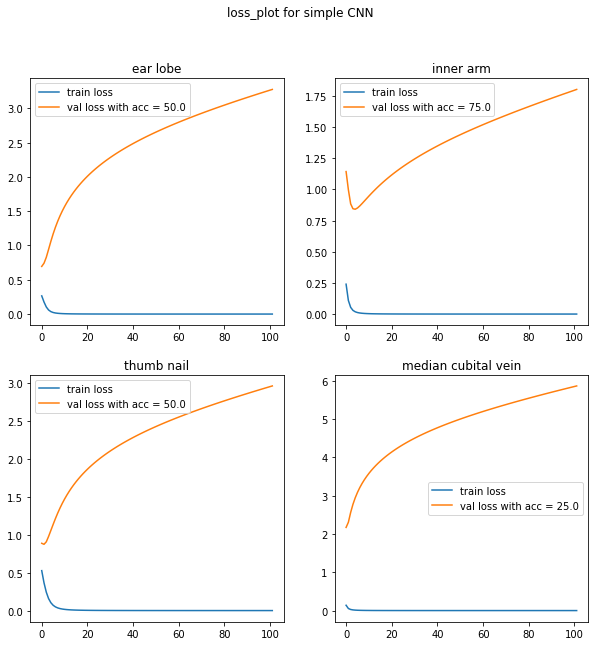

In [28]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',cnnsim_models[-1](spec),'\n',y,'\n val\n',cnnsim_models[-1](val_spec),val_label)

mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'simple CNN')

- ### 6.simple
    - RNN

In [29]:
class RamLSTM(nn.Module):
    def __init__(self, input_size = 1000, hidden_size=100, out_size=2):
        super().__init__()
        self.lstm   = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, out_size)
        
    def forward(self, seq):
        out, (_, _) = self.lstm(seq)
        out = out[:, -1, :] #(B, Hout)

        out = self.linear(out)
        return out
        

In [30]:
model_RNN_for_earloop = RamLSTM().to(device)
model_RNN_for_inarm = RamLSTM().to(device)
model_RNN_for_thumbnail = RamLSTM().to(device)
model_RNN_for_vain = RamLSTM().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_RNN_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_RNN_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_RNN_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_RNN_for_vain.parameters(), lr=0.0001)  

simRNN_models = [model_RNN_for_earloop,model_RNN_for_inarm,model_RNN_for_thumbnail,model_RNN_for_vain]
simRNN_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
simRNN_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [31]:
total_step = len(train_loader0)  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(simRNN_models,simRNN_criterions,simRNN_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 40 == 0:
            with torch.no_grad():
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / len(val_set0)
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1], Loss: 0.0001    ++++++Validation++++++  Loss: 2.19 - Acc: 50.00 
 END OF MODEL for ear lobe with val acc = 50.0
Epoch [5000/5000], Step [1/1], Loss: 0.0001    ++++++Validation++++++  Loss: 1.95 - Acc: 75.00     ++++++Validation++++++  Loss: 1.57 - Acc: 75.00 
 END OF MODEL for inner arm with val acc = 75.0
Epoch [5000/5000], Step [1/1], Loss: 0.0001    ++++++Validation++++++  Loss: 4.28 - Acc: 25.00 
 END OF MODEL for thumb nail with val acc = 25.0
Epoch [5000/5000], Step [1/1], Loss: 0.0001    ++++++Validation++++++  Loss: 5.84 - Acc: 0.00     ++++++Validation++++++  Loss: 5.58 - Acc: 0.00 
 END OF MODEL for median cubital vein with val acc = 0.0


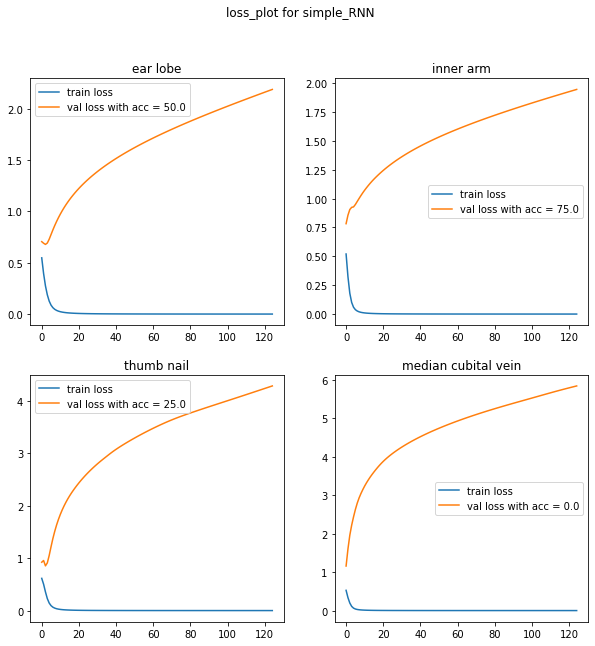

In [32]:
if WATCH_PROB_PREDICT:
    with torch.no_grad():
        print('trainpred ',simRNN_models[-1](spec),'\n',y,'\n val\n',simRNN_models[-1](val_spec),val_label)
        print(criterion(simRNN_models[-1](val_spec),val_label))
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'simple_RNN')

- ## 6.Intermediate
    - RNN dropout

In [33]:
class IntRamLSTM(nn.Module):
    def __init__(self, input_size = 1000, hidden_size=100,hidden_s2 = 14, out_size=2):
        super().__init__()
        self.lstm   = nn.LSTM(input_size, hidden_size, batch_first=True,dropout = 0.5)
        self.linear = nn.Linear(hidden_size, hidden_s2)
        self.linear2 = nn.Linear(hidden_s2, out_size)
        self.do = nn.Dropout(p=.5)
        self.relu = nn.ReLU()
        
    def forward(self, seq):
        out, (_, _) = self.lstm(seq)
        out = out[:, -1, :] #(B, Hout)
        # 
        out = self.linear(out)
        out = self.relu(out)
        self.do(out)

        return self.linear2(out)

In [34]:
model_RNN_for_earloop = IntRamLSTM().to(device)
model_RNN_for_inarm = IntRamLSTM().to(device)
model_RNN_for_thumbnail = IntRamLSTM().to(device)
model_RNN_for_vain = IntRamLSTM().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(model_RNN_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(model_RNN_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(model_RNN_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(model_RNN_for_vain.parameters(), lr=0.0001)  

intRNN_models = [model_RNN_for_earloop,model_RNN_for_inarm,model_RNN_for_thumbnail,model_RNN_for_vain]
intRNN_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
intRNN_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [35]:
total_step = len(train_loader0)  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(intRNN_models,intRNN_criterions,intRNN_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            
            model.train()
            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 40 == 0:
            with torch.no_grad():
                model.eval()
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())

                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / valbatch_size
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)

Epoch [5000/5000], Step [1/1], Loss: 0.0001    ++++++Validation++++++  Loss: 2.63 - Acc: 50.00 
 END OF MODEL for ear lobe with val acc = 50.0
Epoch [5000/5000], Step [1/1], Loss: 0.0001    ++++++Validation++++++  Loss: 2.42 - Acc: 50.00 
 END OF MODEL for inner arm with val acc = 50.0
Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 4.88 - Acc: 25.00 
 END OF MODEL for thumb nail with val acc = 25.0
Epoch [5000/5000], Step [1/1], Loss: 0.0002    ++++++Validation++++++  Loss: 5.87 - Acc: 0.00 
 END OF MODEL for median cubital vein with val acc = 0.0


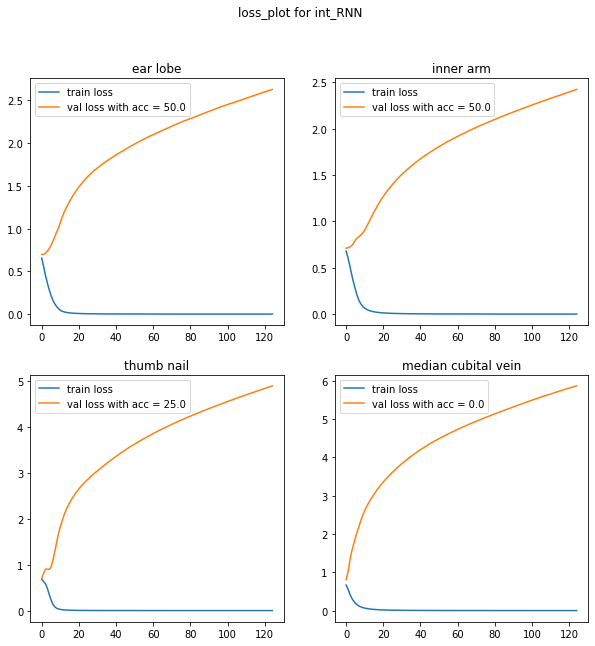

In [36]:
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'int_RNN')


- int CNN
- BUILD by anh

In [37]:
class RamConv1d_bnmx(nn.Module):
    def __init__(self, input_size = 1, hidden_size=50,hidden_size2=10,linear_hidden=14, out_size=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size = 3)      
        self.relu1 = nn.ReLU()                            
        # Convolution Layer 2
        self.conv2 = nn.Conv1d(hidden_size, hidden_size2, kernel_size = 3)     
        self.maxpool1 = nn.MaxPool1d(2)
        self.maxpool2 = nn.MaxPool1d(2)                   
        self.relu2 = nn.ReLU()                           
        
        # Fully connected layers
        self.fc1 = nn.Linear(2480, linear_hidden)
        self.fc2 = nn.Linear(linear_hidden, out_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size2)
        # self.batchnorm3 = nn.BatchNorm1d(50)
    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                                                    
        x = self.batchnorm1(x)
        x = self.relu1(x)
        x = self.maxpool1(x) 
        # Convolution Layer 2
        x = self.conv2(x)               
        x = self.maxpool2(x)
        x = self.relu2(x)
        x = self.batchnorm2(x)
        # Switch from activation maps to vectors
        # x = x.reshape(-1, 24900)
        # print(x.shape)
        x = x.reshape(x.size(0), -1)
        # print(x.shape)
        # Fully connected layer 1
        x = self.fc1(x)
        x = self.relu1(x)
        # Fully connected layer 2
        x = self.fc2(x)
        
        return x

In [38]:
modelcnn_for_earloop = RamConv1d_bnmx().to(device)
modelcnn_for_inarm = RamConv1d_bnmx().to(device)
modelcnn_for_thumbnail = RamConv1d_bnmx().to(device)
modelcnn_for_vain = RamConv1d_bnmx().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(modelcnn_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(modelcnn_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(modelcnn_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(modelcnn_for_vain.parameters(), lr=0.0001)  

cnnINTsim_models = [modelcnn_for_earloop,modelcnn_for_inarm,modelcnn_for_thumbnail,modelcnn_for_vain]
cnnINTsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
cnnINTsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [39]:
total_step = len(train_loader0)  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(cnnINTsim_models,cnnINTsim_criterions,cnnINTsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            model.train()

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            # print(spec.shape)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 490 == 0:
            model.eval()
            with torch.no_grad():
                
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())
                    
                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / len(val_set0)
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)
    

Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 1.03 - Acc: 25.00   ++++++Validation++++++  Loss: 0.65 - Acc: 75.00     ++++++Validation++++++  Loss: 1.03 - Acc: 25.00 
 END OF MODEL for ear lobe with val acc = 25.0
Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 2.07 - Acc: 50.00     ++++++Validation++++++  Loss: 1.77 - Acc: 50.00 
 END OF MODEL for inner arm with val acc = 50.0
Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 6.37 - Acc: 25.00 
 END OF MODEL for thumb nail with val acc = 25.0
Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 6.00 - Acc: 25.00     ++++++Validation++++++  Loss: 4.75 - Acc: 50.00 
 END OF MODEL for median cubital vein with val acc = 25.0


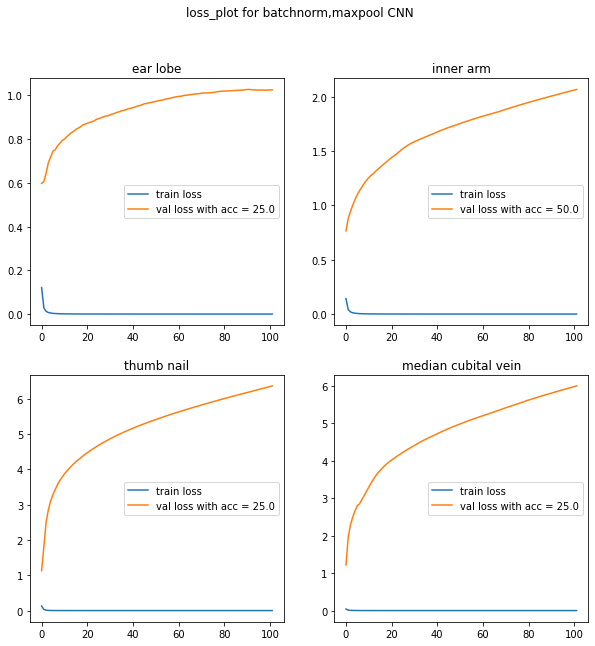

In [40]:
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'batchnorm,maxpool CNN')

- ## int Conv


In [41]:
996 / 4 * 50

12450.0

In [42]:
class RamConv1d_mx(nn.Module):
    def __init__(self, input_size = 1, hidden_size=10,hidden_size2=50,linear_hidden=14, out_size=2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size = 3)      
        self.relu1 = nn.ReLU()                            
        # Convolution Layer 2
        self.conv2 = nn.Conv1d(hidden_size, hidden_size2, kernel_size = 3)     
        self.maxpool1 = nn.MaxPool1d(2)
        self.maxpool2 = nn.MaxPool1d(2)                   
        self.relu2 = nn.ReLU()                           
        self.drop = nn.Dropout(p=0.7)
        # Fully connected layers
        self.fc1 = nn.Linear(12400, 1000)
        self.fc2 = nn.Linear(1000, linear_hidden)
        self.fc3 = nn.Linear(linear_hidden, out_size)
        # self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        # self.batchnorm2 = nn.BatchNorm1d(hidden_size2)
        # self.batchnorm3 = nn.BatchNorm1d(50)
    def forward(self, x):
        
        # Convolution Layer 1                    
        x = self.conv1(x)                                                    
        x = self.relu1(x)
        x = self.maxpool1(x) 
        # Convolution Layer 2
        x = self.conv2(x)  
        x = self.relu2(x)             
        x = self.maxpool2(x)


        # Switch from activation maps to vectors
        # x = x.reshape(-1, 24900)
        # print(x.shape)
        x = x.reshape(x.size(0), -1)
        # print(x.shape)
        # Fully connected layer 1
        x = self.fc1(x)
        x = self.relu1(x)
        # Fully connected layer 2
        x = self.drop(x)
        x = self.fc2(x)
        x = self.relu1(x)
        return self.fc3(x)

In [43]:
modelcnn_for_earloop = RamConv1d_mx().to(device)
modelcnn_for_inarm = RamConv1d_mx().to(device)
modelcnn_for_thumbnail = RamConv1d_mx().to(device)
modelcnn_for_vain = RamConv1d_mx().to(device)


criterion_for_earloop = nn.CrossEntropyLoss()   
optimizer_for_earloop = torch.optim.Adam(modelcnn_for_earloop.parameters(), lr=0.0001)  

criterion_for_inarm= nn.CrossEntropyLoss()   
optimizer_for_inarm = torch.optim.Adam(modelcnn_for_inarm.parameters(), lr=0.0001)  

criterion_for_thumbnail= nn.CrossEntropyLoss()   
optimizer_for_thumbnail = torch.optim.Adam(modelcnn_for_thumbnail.parameters(), lr=0.0001)

criterion_for_vain = nn.CrossEntropyLoss()   
optimizer_for_vain = torch.optim.Adam(modelcnn_for_vain.parameters(), lr=0.0001)  

cnnINTsim_models = [modelcnn_for_earloop,modelcnn_for_inarm,modelcnn_for_thumbnail,modelcnn_for_vain]
cnnINTsim_criterions = [criterion_for_earloop,criterion_for_inarm,criterion_for_thumbnail,criterion_for_vain]
cnnINTsim_optims = [optimizer_for_earloop,optimizer_for_inarm,optimizer_for_thumbnail,optimizer_for_vain]

In [44]:
total_step = len(train_loader0)  #for printing purpose
num_epochs = 5000

train_loss_each_location = []
val_loss_each_location = []
val_acc_each_location = []

for model,criterion,optimizer,each_train_loader,each_val_loader,datasetlabel in zip(cnnINTsim_models,cnnINTsim_criterions,cnnINTsim_optims,train_loader_all,val_loader_all,DATALABEL):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        for i, (spec, y) in enumerate(each_train_loader):  
            model.train()

            spec = spec.reshape(spec.shape[0],1,-1).to(device)
            # print(spec.shape)
            y = y.to(device)
                    
            # Forward pass
            outputs = model(spec)
            loss = criterion(outputs, y)  
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i) % 50 == 0:
                sys.stdout.write('\rEpoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        if (epoch+1) % 149 == 0:
            model.eval()
            with torch.no_grad():
                
                total_val_corr = 0
                for (val_spec, val_label) in each_val_loader:
                    val_spec = val_spec.reshape(val_spec.shape[0],1,-1).to(device)
                    val_label = val_label.to(device)
                    val_yhat = model(val_spec)
                    val_loss = criterion(val_yhat, val_label)

                    train_losses.append(loss.cpu().detach().numpy())
                    val_losses.append(val_loss.cpu().detach().numpy())
                    
                    val_predicted = torch.max(val_yhat, 1)[1]
                    total_val_corr += (val_predicted == val_label).sum()
                val_acc = (total_val_corr * 100) / len(val_set0)
                print(f"    ++++++Validation++++++  Loss: {val_loss:.2f} - Acc: {val_acc:.2f}",end = ' ')
    print(f'\n END OF MODEL for {datasetlabel} with val acc = {val_acc}')
    train_loss_each_location.append(train_losses)
    val_loss_each_location.append(val_losses)
    val_acc_each_location.append(val_acc)
    

Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 3.56 - Acc: 50.00 
 END OF MODEL for ear lobe with val acc = 50.0
Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 2.01 - Acc: 50.00 
 END OF MODEL for inner arm with val acc = 50.0
Epoch [5000/5000], Step [1/1], Loss: 0.0001    ++++++Validation++++++  Loss: 4.74 - Acc: 25.00 
 END OF MODEL for thumb nail with val acc = 25.0
Epoch [5000/5000], Step [1/1], Loss: 0.0000    ++++++Validation++++++  Loss: 8.18 - Acc: 25.00 
 END OF MODEL for median cubital vein with val acc = 25.0


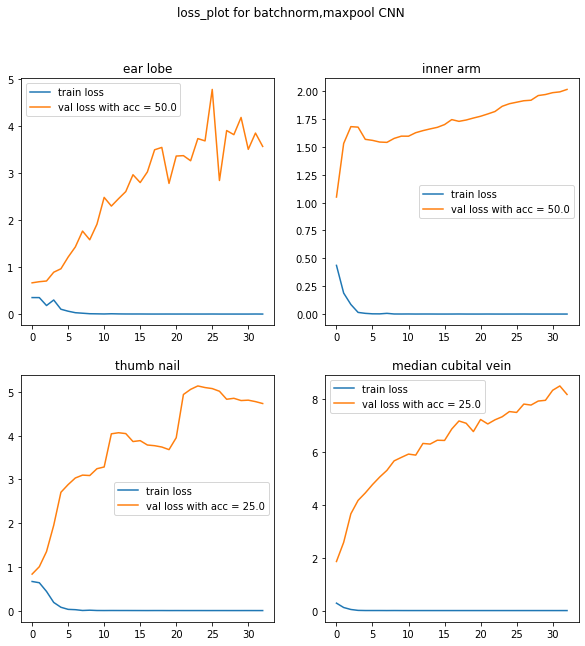

In [45]:
mtp.loss_plot_sub(train_loss_each_location,val_loss_each_location,val_acc_each_location,DATALABEL,'batchnorm,maxpool CNN')